# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 17  PyTorch Logistic Regression

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


# PyTorch Imports


In [76]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

tensorflow:1.2.1
__Python VERSION: 2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
__pyTorch VERSION: 0.2.0_1
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 0
__Devices


#  Load a CSV file for Binary classification

In [120]:
% reset -f

# ! pip install tables

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)

%matplotlib inline


F_NAME_TRAIN= 'data-03-diabetes.csv'
# F_NAME_TRAIN='numerai/numerai_training_data.csv'

# X_df_train= pd.read_csv(F_NAME_TRAIN)
X_df_train= pd.read_csv(F_NAME_TRAIN,header=None, dtype=np.float32)
X_df_train_SINGLE=X_df_train.copy(deep=True)   


# X_df_train_SINGLE.drop('id', axis=1, inplace=True)
# X_df_train_SINGLE.drop('era', axis=1, inplace=True)
# X_df_train_SINGLE.drop('data_type', axis=1, inplace=True)
# # drop the header

# X_df_train_SINGLE.to_csv('numerai/numerai_training_data_clean.csv', header=False)
# X_df_train_SINGLE= pd.read_csv('numerai/numerai_training_data_clean.csv', header=None, dtype=np.float32)

# X_df_train_SINGLE=X_df_train_SINGLE.dropna()
    
answers_1_SINGLE = list (X_df_train_SINGLE[X_df_train_SINGLE.columns[-1]].values)
answers_1_SINGLE= map(int, answers_1_SINGLE)
X_df_train_SINGLE = X_df_train_SINGLE.drop(X_df_train_SINGLE.columns[-1], axis=1)
# X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))  

print(X_df_train_SINGLE.shape)

# (np.where(np.isnan(X_df_train_SINGLE)))
# (np.where(np.isinf(X_df_train_SINGLE)))

# X_df_train_SINGLE.info()

use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)        

# sk learn
trainX, testX, trainY, testY = train_test_split(X_df_train_SINGLE, answers_1_SINGLE, test_size=.22, random_state=999)  

X_df_train_SINGLE.head(5)

(759, 8)


,0,1,2,3,4,5,6,7
0,-0.294118,0.487437,0.180328,-0.292929,0.000000,0.001490,-0.531170,-0.033333
1,-0.882353,-0.145729,0.081967,-0.414141,0.000000,-0.207153,-0.766866,-0.666667
2,-0.058823,0.839196,0.049180,0.000000,0.000000,-0.305514,-0.492741,-0.633333
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,0.000000
4,0.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


#  Create PyTorch GPU tensors

- Note how we transfrom the np arrays

In [121]:


# Train data
x_data_np = np.array(trainX.values, dtype=np.float32)
y_data_np = np.array(trainY, dtype=np.float32)
y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!


print(x_data_np.shape, y_data_np.shape)
print(type(x_data_np), type(y_data_np))

if use_cuda:
    lgr.info ("Using the GPU")    
    X = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch
    Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
else:
    lgr.info ("Using the CPU")
    X = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
    
print(type(X.data), type(Y.data)) # should be 'torch.cuda.FloatTensor'
print(x_data_np.shape, y_data_np.shape)
print(type(x_data_np), type(y_data_np))
    

INFO:__main__:Using the CPU


(592, 8) (592, 1)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.LongTensor'>
(592, 8) (592, 1)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>


In [177]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt



class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer        
#         torch.nn.init.xavier_uniform(self.hidden.weight, gain=np.sqrt(2.0))

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x

linear1=torch.nn.Linear(x_data_np.shape[1], 2, bias=True) 
# xavier initializer
torch.nn.init.xavier_uniform(linear1.weight)
sigmoid = torch.nn.Sigmoid()
# model = torch.nn.Sequential(linear1,dropout, sigmoid)

net = torch.nn.Sequential(linear1, sigmoid)    
net = Net(n_feature=x_data_np.shape[1], n_hidden=100, n_output=2)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

Net (
  (hidden): Linear (8 -> 100)
  (out): Linear (100 -> 2)
)


0 [ 0.6759584]
acc=0.623310810811 log_loss=13.010637602 roc_auc=0.491958666278 
2000 [ 0.45388964]
acc=0.766891891892 log_loss=8.05138497952 roc_auc=0.721339293629 
4000 [ 0.44120336]
acc=0.775337837838 log_loss=7.75966693837 roc_auc=0.732476857421 
6000 [ 0.42901507]
acc=0.783783783784 log_loss=7.46795294922 roc_auc=0.740081299783 
GPU: 20.715 seconds


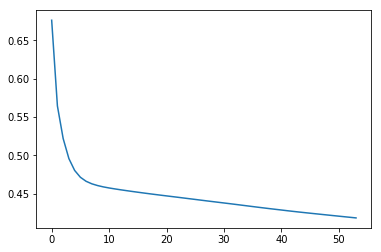

In [178]:
import time
start_time = time.time()    
epochs=8000
all_losses = []

x,y= X,Y

for step in range(epochs):
#     net.train()
    out = net(x)                 # input x and predict based on x
    cost = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
       
    # Keep loss 
    if step % 150 == 0:
        loss = cost.data[0]
        all_losses.append(loss)
        
    if step % 2000 == 0:        
        print(step, cost.data.cpu().numpy())
        # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
        # Use .cpu() to move the tensor to host memory first.        
        prediction = torch.max(F.softmax(out), 1)[1]
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()                
        
        tu = ((pred_y == target_y).mean(),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        print ('acc={} log_loss={} roc_auc={} '.format(*tu))
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

INFO:__main__:Using the CPU


(167, 8) (167, 1)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.LongTensor'>
(167, 8) (167, 1)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
acc=0.77245508982 log_loss=7.85928077678 roc_auc=0.701635514019 


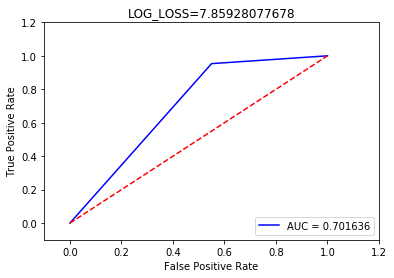

In [179]:
net.eval()

# Validation data
x_data_np_val = np.array(testX.values, dtype=np.float32)
y_data_np_val = np.array(testY, dtype=np.float32)
y_data_np_val=y_data_np_val.reshape((y_data_np_val.shape[0],1)) # Must be reshaped for PyTorch!


print(x_data_np_val.shape, y_data_np_val.shape)
print(type(x_data_np_val), type(y_data_np_val))

if use_cuda:
    lgr.info ("Using the GPU")    
    X_val = Variable(torch.from_numpy(x_data_np_val).cuda()) # Note the conversion for pytorch
    Y_val = Variable(torch.from_numpy(y_data_np_val).type(torch.LongTensor).cuda())
else:
    lgr.info ("Using the CPU")
    X_val = Variable(torch.from_numpy(x_data_np_val)) # Note the conversion for pytorch
    Y_val = Variable(torch.squeeze (torch.from_numpy(y_data_np_val).type(torch.LongTensor)))  #         
    
print(type(X_val.data), type(Y_val.data)) # should be 'torch.cuda.FloatTensor'
print(x_data_np_val.shape, y_data_np_val.shape)
print(type(x_data_np_val), type(y_data_np_val))

x,y= X_val,Y_val

# VALIDATION

predicted_val = (net(X_val).data).float()
# predicted_val = (net(X_val).data > 0.5).float()
# prediction_val = torch.max(F.softmax((net(X_val).data)), 1)[1]
pred_y = prediction_val.data.cpu().numpy()
# pred_y=predicted_val.cpu().numpy()
target_y = Y_val.data.numpy()                

tu = (str ((pred_y == target_y).mean()),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('acc={} log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [180]:
%whos

Variable              Type                Data/Info
---------------------------------------------------
F                     module              <module 'torch.nn.functio<...>torch/nn/functional.pyc'>
F_NAME_TRAIN          str                 data-03-diabetes.csv
FloatTensor           type                <class 'torch.FloatTensor'>
LongTensor            type                <class 'torch.LongTensor'>
Net                   type                <class '__main__.Net'>
R_SCORE_VAL           float64             0.701635514019
ShuffleSplit          ABCMeta             <class 'sklearn.cross_validation.ShuffleSplit'>
StratifiedKFold       ABCMeta             <class 'sklearn.cross_val<...>idation.StratifiedKFold'>
Tensor                type                <class 'torch.FloatTensor'>
Variable              type                <class 'torch.autograd.variable.Variable'>
X                     Variable            Variable containing:\n-0.<...>atTensor of size 592x8]\n
X_df_train            DataFrame  

In [181]:
%reset -f
%whos

Interactive namespace is empty.
